## Проект: вариант 2

**Задание 1. A/B–тестирование**

**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

**1.3 Вопросы**

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
* Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.


In [1]:
import pandas as pd
from urllib.parse import urlencode
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import datasets
import numpy as np
from scipy.stats import norm 
import re
from IPython.display import Image
from IPython.core.display import HTML
from tqdm.auto import tqdm
import pandahouse as ph

In [2]:
# получаем прямую ссылку на файлы
# используем api 

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# ссылки на данные с указанием разделителя csv-файла
links_dic = {
    'groups': ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', ';'],
    'groups_add': ['https://disk.yandex.ru/d/3aARY-P9pfaksg', ','],
    'active_studs': ['https://disk.yandex.ru/d/prbgU-rZpiXVYg', ','],
    'checks': ['https://disk.yandex.ru/d/84hTmELphW2sqQ', ';']
}

# получаем url
for csv_filename, link in links_dic.items():
    final_url = base_url + urlencode(dict(public_key=link[0]))
    response = requests.get(final_url)
    download_url = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=link[1])

Проведем анализ данных

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.id.nunique()

74484

In [5]:
groups.dtypes

id      int64
grp    object
dtype: object

In [6]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
groups_add.id.nunique()

92

In [8]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [9]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_studs.dtypes

student_id    int64
dtype: object

In [12]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [13]:
active_studs.student_id.nunique()

8341

In [14]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks.student_id.nunique()

541

In [17]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Проверим если ли в файле с дополнительными пользователями информация об оплатах пользователей и информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [18]:
checks = checks.rename(columns={'student_id':'id'})
active_studs = active_studs.rename(columns={'student_id':'id'})

In [19]:
checks.merge(groups_add, on= 'id').shape[0]

1

In [20]:
active_studs.merge(groups_add, on= 'id').shape[0]

13

Пользователи есть, следовательно объединяем данные в 1 df

In [21]:
groups_total = pd.concat([groups, groups_add])

In [22]:
groups_total.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [23]:
groups_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [24]:
groups_total.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

In [25]:
groups_total.shape[0]

74576

In [26]:
groups_total.grp.value_counts(normalize=False)

B    59883
A    14693
Name: grp, dtype: int64

In [27]:
# проверяем кол-во активных пользовтелей, которых нет в общем списке 
active_studs.query(' id not in @groups_total.id').shape[0]

0

In [28]:
# проверяем кол-во оплативших пользовтелей, которых нет в общем списке 
checks.query(' id not in @groups_total.id').shape[0]

0

In [29]:
# проверяем кол-во оплативших пользовтелей, которых нет в списке активных, возможно это продление подписки или т.п.
checks.query(' id not in @active_studs.id').shape[0]

149

In [30]:
# распределение активных пользователей по группам
groups_total.query(' id in @active_studs.id').grp.value_counts(normalize=False)

B    6803
A    1538
Name: grp, dtype: int64

In [31]:
# распределение оплативших пользователей по группам 
groups_total.query(' id in @checks.id').grp.value_counts(normalize=False)

B    434
A    107
Name: grp, dtype: int64

In [32]:
# распределение оплативших не активных пользователей по группам 
not_active_but_paid=checks.query(' id not in @active_studs.id')
groups_total.query(' id in @not_active_but_paid.id').grp.value_counts(normalize=False)

B    120
A     29
Name: grp, dtype: int64

In [33]:
not_active_but_paid.shape[0]


149

In [34]:
# распределение активных и оплативших пользователей
active_and_paid = groups_total.query('id in @active_studs.id & id in @checks.id')
active_and_paid.grp.value_counts(normalize=False)

B    314
A     78
Name: grp, dtype: int64

In [35]:
active_and_paid.grp.shape[0]

392

In [36]:
# распределение активных и не оплативших пользователей
active_and_not_paid = groups_total.query('id in @active_studs.id & id not in @checks.id')
active_and_not_paid.grp.value_counts(normalize=False)

B    6489
A    1460
Name: grp, dtype: int64

**Финальное распределение пользовтаелей проанализированной информации**

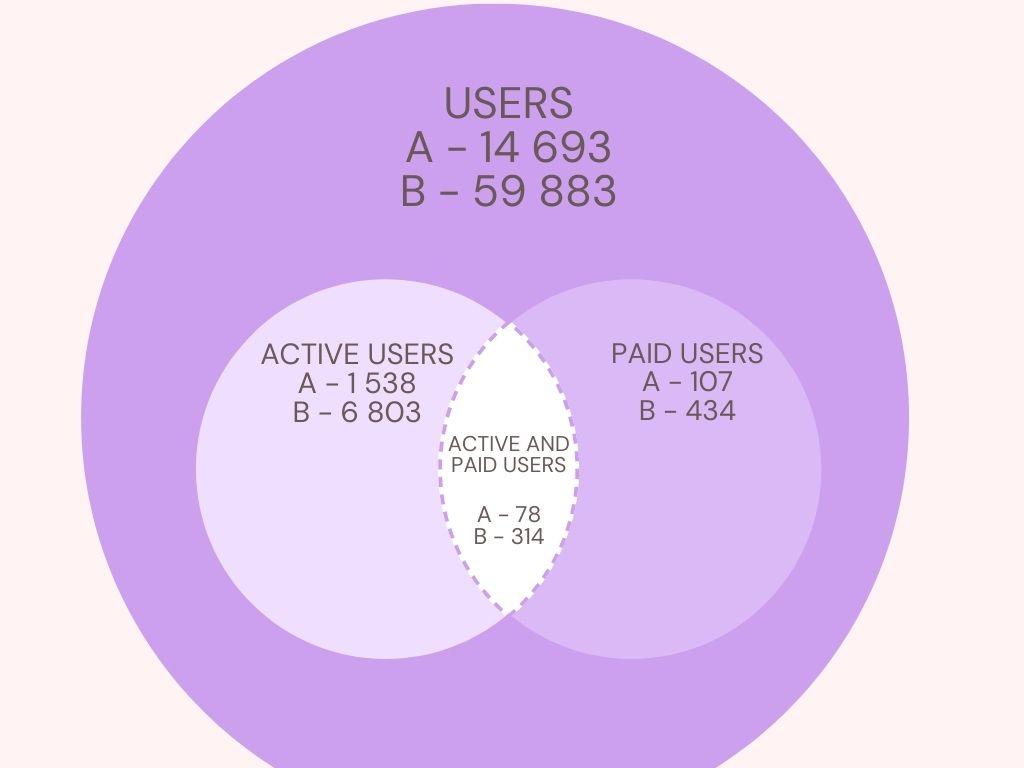

In [37]:
Image(filename = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/Final_project/1.jpg", width=400, height=400)

Т.к. в поставленной задаче ничего не говорится про пользователей, которые были не активны, но оплата от них прошла (это возможно автоматическое списание средст или ошибки в логах, возможно пользователи были активны) Скорее всего эти пользователи не видели новую механику оплаты услуг. Поэтому исключаем пользователей которые были не активны, но с оплатой - 149 users. Для дальнейшего анализа используем список активных пользователей с оплатой A= 78 B = 314 пользователей, в группе **В** значительно больше пользователей

In [38]:
#Объединяем в 1 df нашу выборку активных пользователей с оплатой и далее объединяем с общим количество активных 
df_users = (groups_total
            .merge(active_studs
            .merge(checks, how='left',on='id'),how='right',on='id').fillna(0))


df_users.head()

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [39]:
#Переведем оплаты пользователей в 1 и 0 
df_users['paid'] =df_users.rev.apply(lambda x: 0 if x==0 else 1)

In [40]:
#Разобъем наш df на 5 групп:
# 1 Группа А активные и оплатившие
# 2 Группа В активные и оплатившие
# 3 Группа А активные
# 4 Группа В активные
# 5 Активные и оплатившие

In [41]:
a_paid = df_users.query('rev > 0 and grp == "A"')
b_paid = df_users.query('rev > 0 and grp == "B"')
a_act = df_users.query('grp == "A"')
b_act = df_users.query('grp == "B"')
act_and_paid = df_users.query('rev > 0')

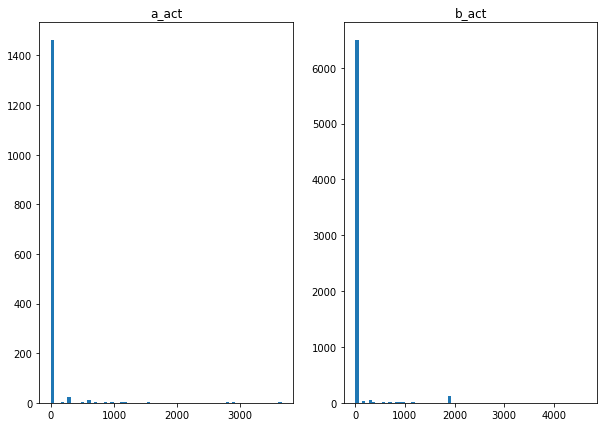

In [42]:
# Посмотрим на распределение наших выборок и описание основных статистик
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
axs[0].set_title('a_act')
axs[1].set_title('b_act')
a = axs[0].hist(a_act['rev'], bins=70)
b = axs[1].hist(b_act['rev'], bins=70)

In [43]:
a_act_desc = a_act.drop(columns=['grp','id','paid']).describe().rename(columns={'rev':'a_act'})
b_act_desc = b_act.drop(columns=['grp','id','paid']).describe().rename(columns={'rev':'b_act'})
pd.concat([a_act_desc, b_act_desc], axis=1)

,a_act,b_act
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


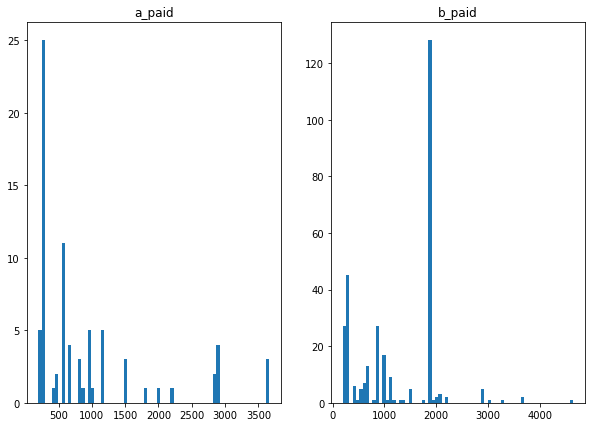

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
axs[0].set_title('a_paid')
axs[1].set_title('b_paid')
c = axs[0].hist(a_paid['rev'], bins=70)
d = axs[1].hist(b_paid['rev'], bins=70)

In [45]:
a_paid_desc = a_paid.drop(columns=['grp','id','paid']).describe().rename(columns={'rev':'a_paid'})
b_paid_desc = b_paid.drop(columns=['grp','id','paid']).describe().rename(columns={'rev':'b_paid'})
pd.concat([a_paid_desc, b_paid_desc], axis=1)

,a_paid,b_paid
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


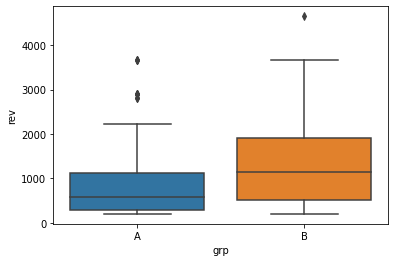

In [46]:
# построим боксплотов активные и оплатившие
sns.boxplot(data=act_and_paid, y='rev', x='grp')

## На какие метрики Вы смотрите в ходе анализа и почему?

* **Конверсия (conversion rate, CR)** — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей. - Показывает насколько пользователи хотят или им удобно совершать покупки у нас в продукте
Показатели доходов:
* **ARPPU (Average revenue per paying user)** - основная доходная метрики продукта.
* **ARPU (Average revenue per user)** - основная доходная метрики продукта.

## CR

In [47]:
CR_a = round(a_paid.id.count() / a_act.id.count(),3)
CR_b = round(b_paid.id.count() / b_act.id.count(),3)
CR_diff = round(CR_b - CR_a,3)
CR_diff

-0.005

In [48]:
CR_a_vs_b = round((CR_b / CR_a)-1,3)
'{:.2%}'.format(CR_a_vs_b)

'-9.80%'

## ARPPU

In [49]:
ARPPU_a = round(a_paid.rev.mean(),3)
ARPPU_b = round(b_paid.rev.mean(),3)
ARPPU_diff = round(ARPPU_b-ARPPU_a,3)
ARPPU_diff

324.289

In [50]:
ARPPU_a_vs_b = round((ARPPU_b/ARPPU_a)-1,3)
'{:.2%}'.format(ARPPU_a_vs_b)

'34.70%'

## ARPU

In [51]:
ARPU_a = round(a_paid.rev.sum() / a_act.id.count(),3)
ARPU_b = round(b_paid.rev.sum() / b_act.id.count(),3)
ARPU_diff = round(ARPU_b-ARPU_a,3)
ARPU_diff

10.712

In [52]:
ARPU_a_vs_b = round((ARPU_b/ARPU_a)-1,3)
'{:.2%}'.format(ARPU_a_vs_b)

'22.60%'

Предлагаем Вам ответить на следующие вопросы:

* Имеются ли различия в показателях и с чем они могут быть связаны? **Да, имеются**
* CR снизился ~10% 
* ARPPU - прирост ~35%
* ARPU - прирост ~23%

**Следовательно можно сделать вывод что конверсия снижается за счет снижения кол-ва мелких покупок, т.к. ARPPU и ARPU значительно выросли и увеличили средний чек**

**Являются ли эти различия статистически значимыми?**
Из описания оснонвных статистик видно большое кол-во выбросов в выбрках, а также размеры выборок очень сильно различаются

Что мы можем сделать дальше с этим? Что будет лучше отражать центральную тенденцию? В данном случае наверное медиана поможет убрать выбросы, но можем ли мы использовать ЦПТ, чтобы построить доверительный интервал для медианы? На данный момент не можем, поэтому используем **бутстрап**

In [53]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it = 1000,                      # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph = True,                        # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор програсса
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):       # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True               # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_2-samples_1)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # доверительный интервал 
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

In [54]:
#задаем через функцию интересующий нас параметр для CR
def func(x):
    return sum(x) / len(x)

Сформулируем наши гипотезы

**CR**

H0: CR в двух группах одинаковые.
H1: CR в двух группах различаются.

**ARPU**

H0: ARPU в двух группах одинаковые.
H1: ARPU в двух группах различаются.

**ARPPU**

H0: ARPPU в двух группах одинаковые.
H1: ARPPU в двух группах различаются.

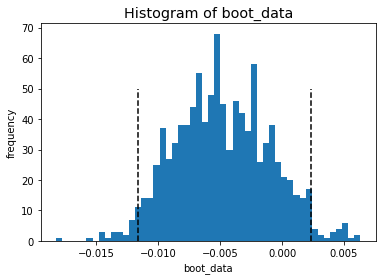

{'ci':               0
 0.025 -0.011613
 0.975  0.002352,
 'p_value': 0.2041731175254098}

In [55]:
get_bootstrap(a_act.paid, b_act.paid, statistic = func)

**0 попадает в доверительный интервал, нулевая гипотеза на заданном уровне значимости принимается**

**Значимых различий в CR в двух группах нет**

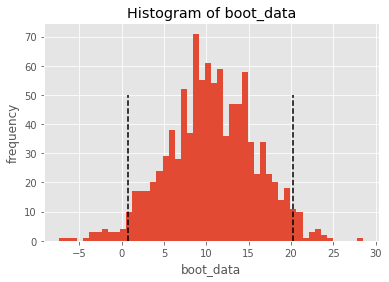

{'ci':                0
 0.025   0.718294
 0.975  20.301901,
 'p_value': 0.03972099890881768}

In [59]:
get_bootstrap(a_act.rev, b_act.rev)

**0 не попадает в доверительный интервал, нулевая гипотеза на заданном уровне значимости не принимается**

**Значимых различий в ARPU в двух группах есть**

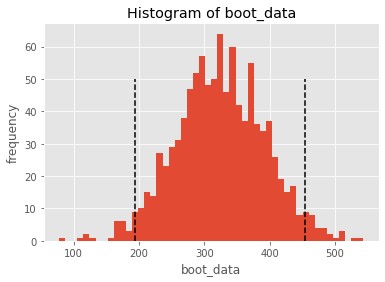

{'ci':                 0
 0.025  193.953275
 0.975  455.117767,
 'p_value': 1.6086402618934834e-06}

In [57]:
get_bootstrap(a_paid.rev, b_paid.rev)

**0 не попадает в доверительный интервал, нулевая гипотеза на заданном уровне значимости не принимается**

**Значимых различий в ARPPU в двух группах есть**

**Стоит ли запускать новую механику на всех пользователей?**

Да,новая механика оплаты услуг на сайте увеличивает ARPU и ARPPU статистически значимо, различие в конверсии (CR) статистически не потвердились

## Задание 2. SQL

**2.1.1 Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.





**2.1.2 Задача** 

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

**В задании говориться про текущий месяц, но в таблице данные только за октябрь 2021 года, скорее всего наш коллега очень спешил и допустил ошибку в выгрузке данных**

**Поэтому составим 2 запроса 1) Запрос для текущего месяца 2)Запрос для дат, которые есть в табличке**

In [60]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [61]:

q = '''
SELECT COUNT(DISTINCT st_id) as stodents_more_20_peas -- считаем кол-во студентов сделавших более 20 заданий

FROM 

(SELECT st_id,	timest,

SUM(correct) as sum_peas 							-- считаем кол-во заданий

FROM default.peas

WHERE extract(Month from timest) = 9 AND extract(Year from timest) = 2022 -- выбираем текущий месяц

GROUP BY timest,st_id								-- группируем по месяцу и id студента

HAVING sum_peas >=20)
    '''
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,stodents_more_20_peas
0,0


In [62]:
e = '''
SELECT COUNT(DISTINCT st_id) as stodents_more_20_peas -- считаем кол-во студентов сделавших более 20 заданий

FROM 

(SELECT st_id,	toMonth(toStartOfMonth(timest)) as MONTH,

SUM(correct) as sum_peas 							-- считаем кол-во заданий

FROM default.peas

GROUP BY MONTH,st_id								-- группируем по месяцу и id студента

HAVING sum_peas >=20)
    '''
e_test = ph.read_clickhouse(query=e, connection=connection_default)
e_test

,stodents_more_20_peas
0,136


**2.2 Оптимизация воронки**

**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

1)-- Отбираем активных студентов из таблицы peas,те кто выполнил более 10 горошин - 1, менее 0

2)-- Отбираем активных студентов по математике из таблицы peas, те кто выполнил более 2 горошин - 1, менее 0

3)-- Отбираем из таблицы default.final_project_check данные, получаем список оплативших курс и список оплативших курс по математике

4)--Объединяем активных студентов с активными студентами по математике 1 и 2 запрос

5)-- Объединяем шаг 4 с таблицей default.studs и добавляем Метку ученика в данном эксперименте, а также добавляем списки оплативших
6)-- Считаем метрики, финальный объединенный запрос, группировка по групам

**-- Отбираем активных студентов из таблицы peas,те кто выполнил более 10 горошин - 1, менее 0**

SELECT ACT_MORE_10.st_id,
MAX(CASE WHEN ACT_MORE_10.active_stud >= 10 THEN 1 ELSE 0 END) AS active_total
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
GROUP BY MONTH,st_id,subject) AS ACT_MORE_10
GROUP BY st_id

**-- Отбираем активных студентов по математике из таблицы peas, те кто выполнил более 2 горошин - 1, менее 0**

SELECT ACT_MORE_2.st_id,
MAX(CASE WHEN ACT_MORE_2.active_stud >= 2 THEN 1 ELSE 0 END) AS active_M
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
WHERE subject = 'Math'
GROUP BY MONTH,st_id,subject) AS ACT_MORE_2
GROUP BY st_id

**-- Отбираем из таблицы default.final_project_check получаем список оплативших курс и список оплативших курс по математике**

SELECT st_id, SUM(money) AS money,
    1 AS any_subject,
    MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS math_subject
FROM default.final_project_check fpc
GROUP BY st_id

**--Объединяем активных студентов с активными студентами по математике**

SELECT A.st_id, A.active_total,A_m.active_M
FROM (SELECT ACT_MORE_10.st_id,
MAX(CASE WHEN ACT_MORE_10.active_stud >= 10 THEN 1 ELSE 0 END) AS active_total
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
GROUP BY MONTH,st_id,subject) AS ACT_MORE_10
GROUP BY st_id) as A
INNER JOIN (SELECT ACT_MORE_2.st_id,
MAX(CASE WHEN ACT_MORE_2.active_stud >= 2 THEN 1 ELSE 0 END) AS active_M
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
WHERE subject = 'Math'
GROUP BY MONTH,st_id,subject) AS ACT_MORE_2
GROUP BY st_id) as A_m
ON A.st_id=A_m.st_id

**-- Объединяем с таблицей default.studs и добавляем Метку ученика в данном эксперименте, а также добавляем списки оплативших**

SELECT A.st_id, A.active_total,A_m.active_M, studs.test_grp,C.money,C.any_subject,C.math_subject
FROM (SELECT ACT_MORE_10.st_id,
MAX(CASE WHEN ACT_MORE_10.active_stud >= 10 THEN 1 ELSE 0 END) AS active_total
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
GROUP BY MONTH,st_id,subject) AS ACT_MORE_10
GROUP BY st_id) as A
INNER JOIN (SELECT ACT_MORE_2.st_id,
MAX(CASE WHEN ACT_MORE_2.active_stud >= 2 THEN 1 ELSE 0 END) AS active_M
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
WHERE subject = 'Math'
GROUP BY MONTH,st_id,subject) AS ACT_MORE_2
GROUP BY st_id) as A_m
ON A.st_id=A_m.st_id
INNER JOIN -- добавляем test / control 
default.studs     
ON A.st_id = studs.st_id
LEFT JOIN -- добавляем оплативших
(SELECT st_id, SUM(money) AS money,
    1 AS any_subject,
    MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS math_subject
FROM default.final_project_check fpc
GROUP BY st_id) as C
ON A.st_id=C.st_id


**-- Считаем метрики, финальный объединенный запрос, группировка по групам**

**Финальный запрос выполняем через pandahouse**


In [63]:
w = '''
SELECT 
studs.test_grp,
ROUND(COALESCE(SUM(C.money), 0) / COUNT(A.st_id),2) AS ARPU,
ROUND(COALESCE(SUM(C.money), 0) / SUM(A.active_total),2) AS ARPAU,
ROUND(COALESCE(SUM(C.any_subject), 0) / COUNT(A.st_id),3) AS CR,
ROUND(SUM(CASE WHEN A.active_total = 1 AND C.any_subject = 1 THEN 1 ELSE 0 END) / SUM(A.active_total),4) AS CR_act,
ROUND(SUM(CASE WHEN A_m.active_M = 1 AND C.math_subject = 1 THEN 1 ELSE 0 END) / SUM(A_m.active_M),4) AS CR_math
FROM (SELECT ACT_MORE_10.st_id,
MAX(CASE WHEN ACT_MORE_10.active_stud >= 10 THEN 1 ELSE 0 END) AS active_total
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
GROUP BY MONTH,st_id,subject) AS ACT_MORE_10
GROUP BY st_id) as A
INNER JOIN (SELECT ACT_MORE_2.st_id,
MAX(CASE WHEN ACT_MORE_2.active_stud >= 2 THEN 1 ELSE 0 END) AS active_M
FROM
(SELECT st_id,subject,										
toMonth(toStartOfMonth(timest)) as MONTH,			
SUM(correct) as active_stud							
FROM default.peas
WHERE subject = 'Math'
GROUP BY MONTH,st_id,subject) AS ACT_MORE_2
GROUP BY st_id) as A_m
ON A.st_id=A_m.st_id
INNER JOIN -- добавляем test / control 
default.studs     
ON A.st_id = studs.st_id
LEFT JOIN -- добавляем оплативших
(SELECT st_id, SUM(money) AS money,
    1 AS any_subject,
    MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS math_subject
FROM default.final_project_check fpc
GROUP BY st_id) as C
ON A.st_id=C.st_id
GROUP BY test_grp
    '''
w_test = ph.read_clickhouse(query=w, connection=connection_default)
w_test

,studs.test_grp,ARPU,ARPAU,CR,CR_act,CR_math
0,control,10094.34,13048.78,0.113,0.0976,0.0612
1,pilot,18000.00,27931.03,0.133,0.1724,0.0952


## Задание 3. Python
**3.1 Задача**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [64]:
#Наш рабочий ДФ
checks = checks.rename(columns={'student_id':'id'}).assign(payments = 1)
active_studs = active_studs.rename(columns={'student_id':'id'}).assign(act = 1)
df_users = (groups.merge(active_studs,how='outer',on='id')
            .merge(checks, how='outer',on='id'))

df_users.head()

,id,grp,act,rev,payments
0,1489,B,NaN,NaN,NaN
1,1627,A,1.0,990.0,1.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [65]:
# Получаем и сохраняем файл
def get_data_new(link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    download_url = response.json()['href']
    df = pd.read_csv(download_url, sep=',')
    
    download_response = requests.get(download_url)
    with open('group_2.csv', 'wb') as f:
            f.write(download_response.content)

In [66]:
# переименовываем колонки в зависимости от типа данных
def columns_rename(df):
    if str(df.iloc[0, 0]).isalpha():
        df.columns = ['grp', 'id']
    else:
        df.columns = ['id', 'grp']

In [67]:
def cal_metric(work_df, link_or_file):
    
    if link_or_file.startswith('https://'): #проверяем ссылка это или файл
        
        get_data_new(link_or_file)
        
        # открываем файл
        df = pd.read_csv('group_2.csv', sep=',')
    else:
        df = pd.read_csv(link_or_file, sep=',')
        
    columns_rename(df)
    
    new_df = work_df.merge(df, how='outer', on = 'id')     #мержим новый и старый дф
    new_df['grp_x'] = new_df.grp_x.fillna('')                
    new_df['grp_y'] = new_df.grp_y.fillna('')               #убираем NaN
    new_df['grp'] = new_df.grp_x + new_df.grp_y             #объединяем столбцы
    new_df= new_df.drop(['grp_x','grp_y'],axis=True)        #удаляем не нужные столбцы
    new_df =(new_df.copy().dropna(subset=['act', 'grp']))   #удаляем NA в столбцах после джоина
    new_df['payments'] = new_df.payments.fillna(0)          #меняем NA на 0 
    new_df['rev'] = new_df.rev.fillna(0)
    
    # Фильтруем данные для расчетов
    
    A_paid = new_df.query('grp =="A"').payments               
    B_paid = new_df.query('grp =="B"').payments
    A_rev = new_df.query('grp =="A"').rev
    B_rev = new_df.query('grp =="B"').rev
    A_rev_paid = new_df.query('rev > 0 and grp =="A"').rev
    B_rev_paid = new_df.query('rev > 0 and grp =="B"').rev
    
        #считаем CR
    CR_A = func(A_paid)
    CR_B = func(B_paid)
    CR_p_value = get_bootstrap(A_paid, B_paid,statistic=func,
                                   graph = False,show_progress = False)["p_value"]
        # считаем ARPU
    ARPU_A = A_rev.mean()
    ARPU_B = B_rev.mean()
    ARPU_p_value = get_bootstrap(A_rev, B_rev,
                                     graph = False,
                                     show_progress = False)["p_value"]
        #считаем ARPPU
    ARPPU_A = A_rev_paid.mean()
    ARPPU_B = B_rev_paid.mean()
    ARPPU_p_value = get_bootstrap(A_rev_paid,B_rev_paid,
                                      graph = False,
                                      show_progress = False)["p_value"]
    #Формируем финальный df
    Final_full_df = pd.DataFrame({"Group":['A','B'],
                                  "CR":[CR_A,CR_B],"ARPU":[ARPU_A,ARPU_B],"ARPPU":[ARPPU_A,ARPPU_B],
                                  "CR_p_value":[CR_p_value,0],"ARPU_p_value":[ARPU_p_value,0],
                                  "ARPPU_p_value":[ARPPU_p_value,0]})
    Final_full_df= round(Final_full_df,3)

        # сбрасываем индексы
    Final_full_df.reset_index(drop=True, inplace=True)  

    return Final_full_df

In [68]:
finallll = cal_metric(df_users,'https://disk.yandex.ru/d/3aARY-P9pfaksg')
finallll

,Group,CR,ARPU,ARPPU,CR_p_value,ARPU_p_value,ARPPU_p_value
0,A,0.051,47.347,933.590,0.233,0.037,0.0
1,B,0.046,58.059,1257.879,0.000,0.000,0.0


In [69]:
def visualize_plots(df):
    
    sns.set_theme(style="dark")
    fig, axs = plt.subplots(ncols=3, figsize=(19, 5))

    sns.barplot(x="Group", y="CR", data=df, ax=axs[0]).set_title('CR')
    sns.barplot(x="Group", y="ARPU", data=df, ax=axs[1]).set_title('ARPU')
    sns.barplot(x="Group", y="ARPPU", data=df, ax=axs[2]).set_title('ARPPU')

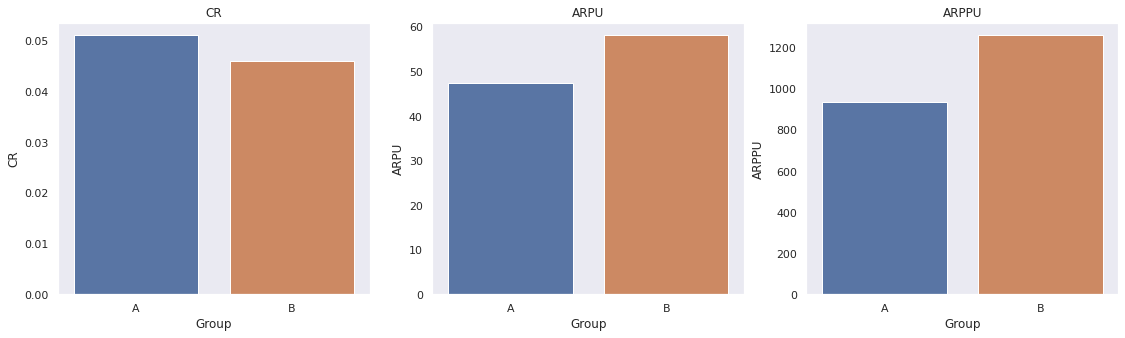

In [70]:
visualize_plots(finallll)